In [68]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [69]:
def show_cv2_image(image, title, cmap=None):
#     showing images read by cv2 by matplotlib
    plt.rcParams['figure.dpi'] = 200
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.show()

In [70]:
planes_image_grayscale = cv2.imread('planes.png', cv2.IMREAD_GRAYSCALE)

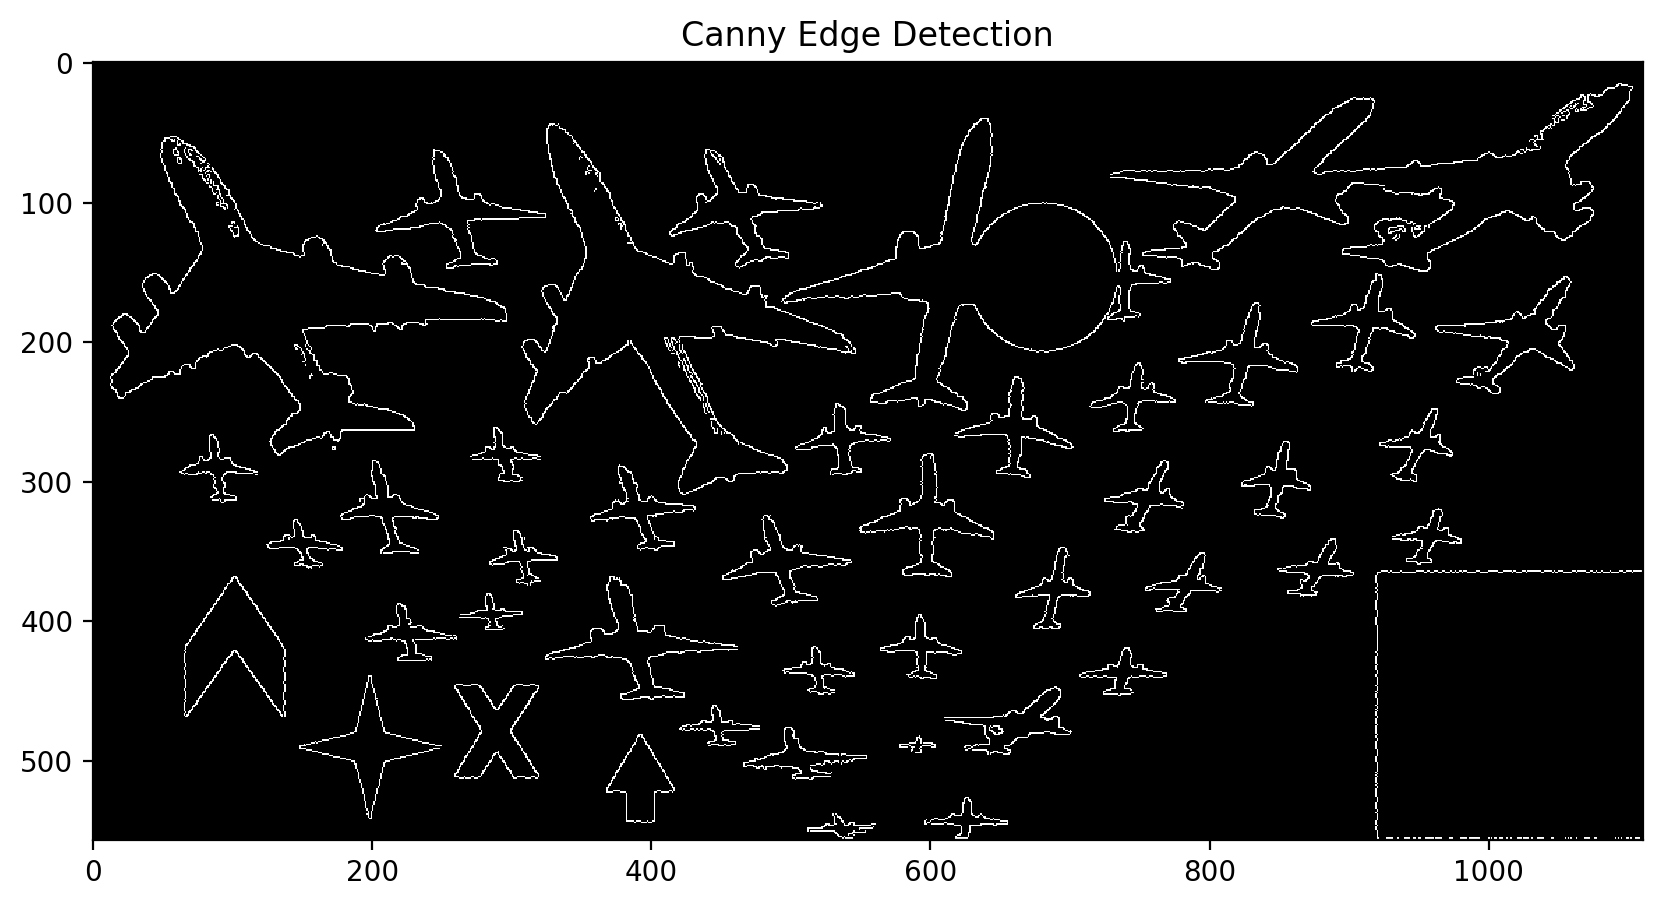

In [71]:
# Canny edge detection with peoper thresholds
edges_image = cv2.Canny(planes_image_grayscale, 500, 800)
show_cv2_image(edges_image, 'Canny Edge Detection', cmap='gray')

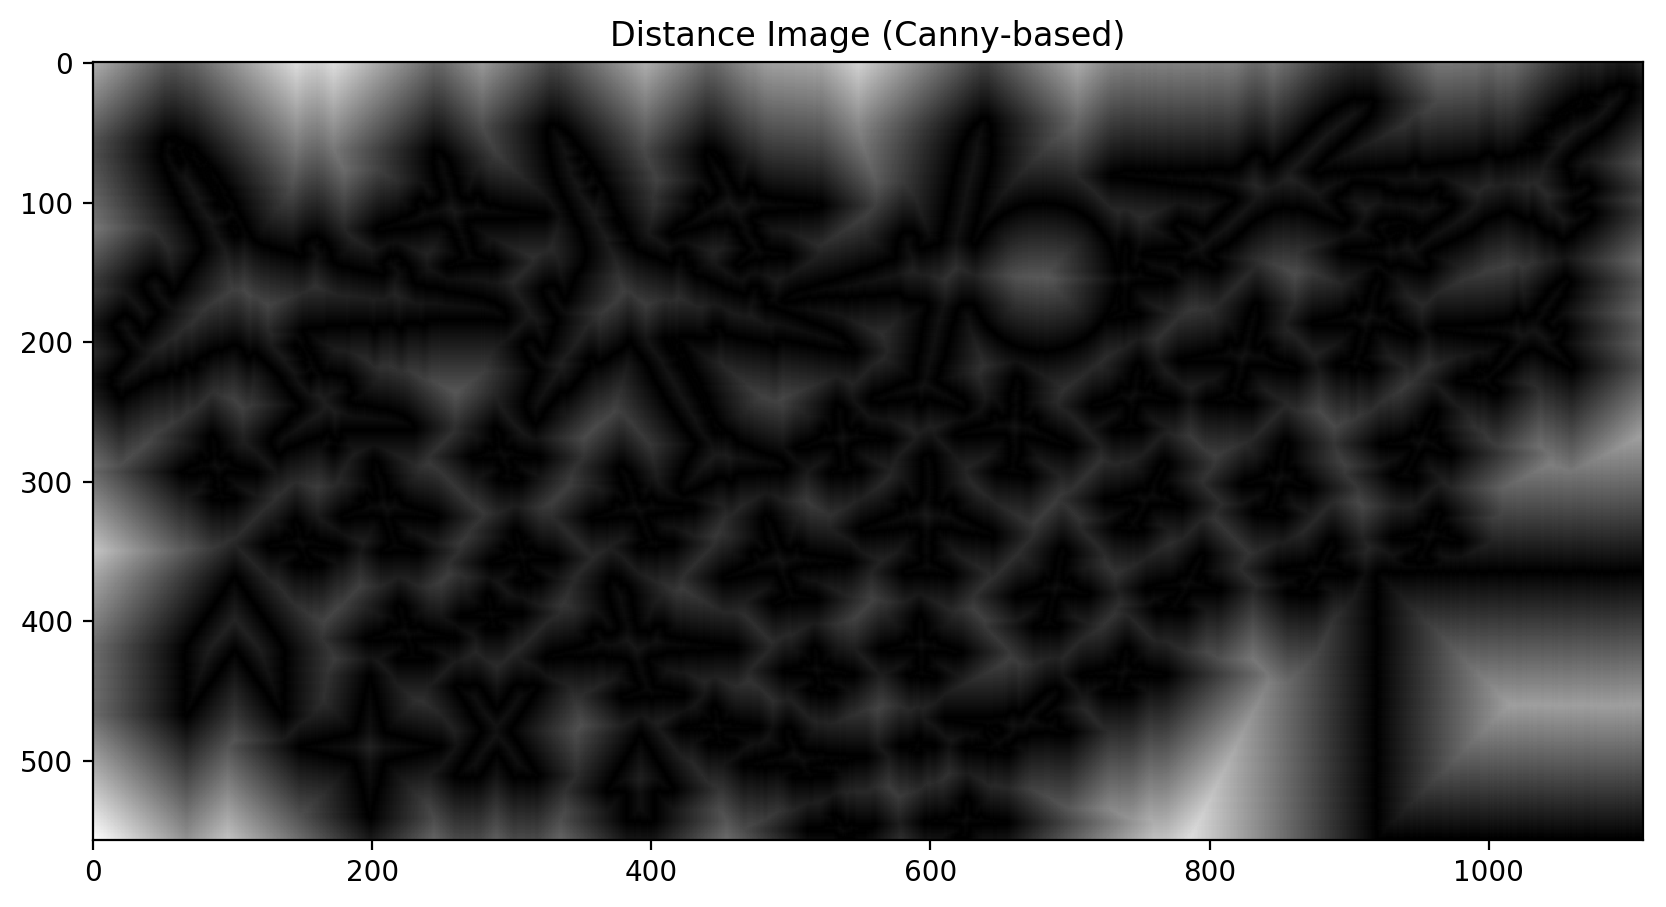

In [72]:
# getting transform from edges
distance_image = cv2.distanceTransform(255 - edges_image, cv2.DIST_L1, 3)
show_cv2_image(distance_image, 'Distance Image (Canny-based)', cmap='gray')

In [83]:
# findong match points
match_points = []
threshold = 0.0085
for i in range(1, 19):
#     reading template
    template = cv2.imread('templates/template%d.png' % i, cv2.IMREAD_GRAYSCALE)
#     convolution
    conv_result = cv2.filter2D(distance_image, -1, template)
    sum_edges = np.sum(template)
#     getting Chamfer distance
    chamfer_distance = ((conv_result / sum_edges) ** 0.5) / 3
#     normalizing Chamfer distance to [0,1]
    min_value, _, _, _ = cv2.minMaxLoc(chamfer_distance)
    chamfer_distance = chamfer_distance - min_value
    _, max_value, _, _ = cv2.minMaxLoc(chamfer_distance)
    chamfer_distance = chamfer_distance / max_value
    
    template_height, template_width = template.shape
    for i in range(chamfer_distance.shape[0]):
        for j in range(chamfer_distance.shape[1]):
            if chamfer_distance[i, j] < threshold:
#                 saving points with box sizes and chamfer distance
                match_points.append([i, j, template_width, template_height, chamfer_distance[i, j]])

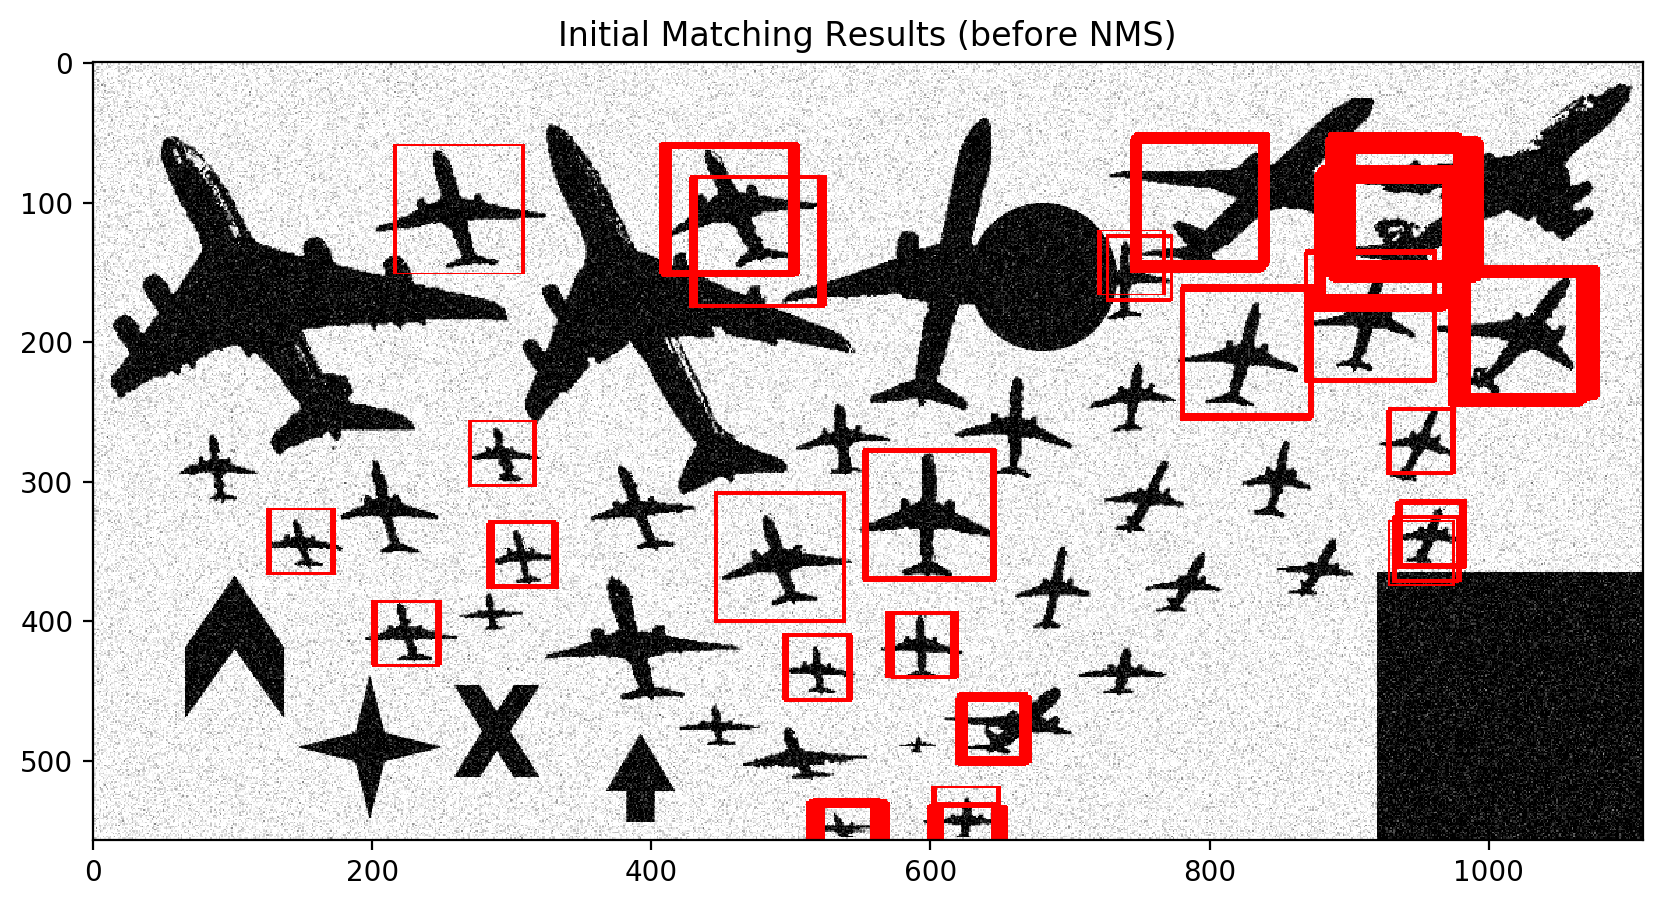

In [74]:
# showing initial results
planes_image_rgb = cv2.imread('planes.png')
for match_point in match_points:
    planes_image_rgb = cv2.rectangle(planes_image_rgb,
                                     (match_point[1] - int(match_point[3] / 2), match_point[0] - int(match_point[2] / 2)),
                                     (match_point[1] + int(match_point[3] / 2), match_point[0] + int(match_point[2] / 2)), (255, 0, 0),
                                     1)
show_cv2_image(planes_image_rgb, 'Initial Matching Results (before NMS)')

In [75]:
# Non maximum Suppression function
def NMS(match_points, threshold):
    results = []
#     descending sort by distance
    sorted_points = sorted(match_points, key=lambda x: (-x[4], x[0], x[1], x[2], x[3]))
    while (len(sorted_points) != 0):
        selected_point = sorted_points.pop(0)
        results.append(selected_point)
        if len(selected_point) == 0:
            break
        i = 1
        while i < len(sorted_points):
            point = sorted_points[i]
#             getting union and intersectionbox limits
            outer_max_i = max(point[0] + point[2] / 2, selected_point[0] + selected_point[2] / 2)
            inner_max_i = min(point[0] + point[2] / 2, selected_point[0] + selected_point[2] / 2)
            outer_min_i = min(point[0] - point[2] / 2, selected_point[0] - selected_point[2] / 2)
            inner_min_i = max(point[0] - point[2] / 2, selected_point[0] - selected_point[2] / 2)
            outer_max_j = max(point[1] + point[3] / 2, selected_point[1] + selected_point[3] / 2)
            inner_max_j = min(point[1] + point[3] / 2, selected_point[1] + selected_point[3] / 2)
            outer_min_j = min(point[1] - point[3] / 2, selected_point[1] - selected_point[3] / 2)
            inner_min_j = max(point[1] - point[3] / 2, selected_point[1] - selected_point[3] / 2)
            union = (outer_max_i - outer_min_i) * (outer_max_j - outer_min_j)
            if inner_max_i < inner_min_i or inner_max_j < inner_min_j:
                intersection = 0
            else:
                intersection = (inner_max_i - inner_min_i) * (inner_max_j - inner_min_j)
#             applying deletion
            if intersection / union > threshold:
                sorted_points.pop(i)
            else:
                i += 1
    return results

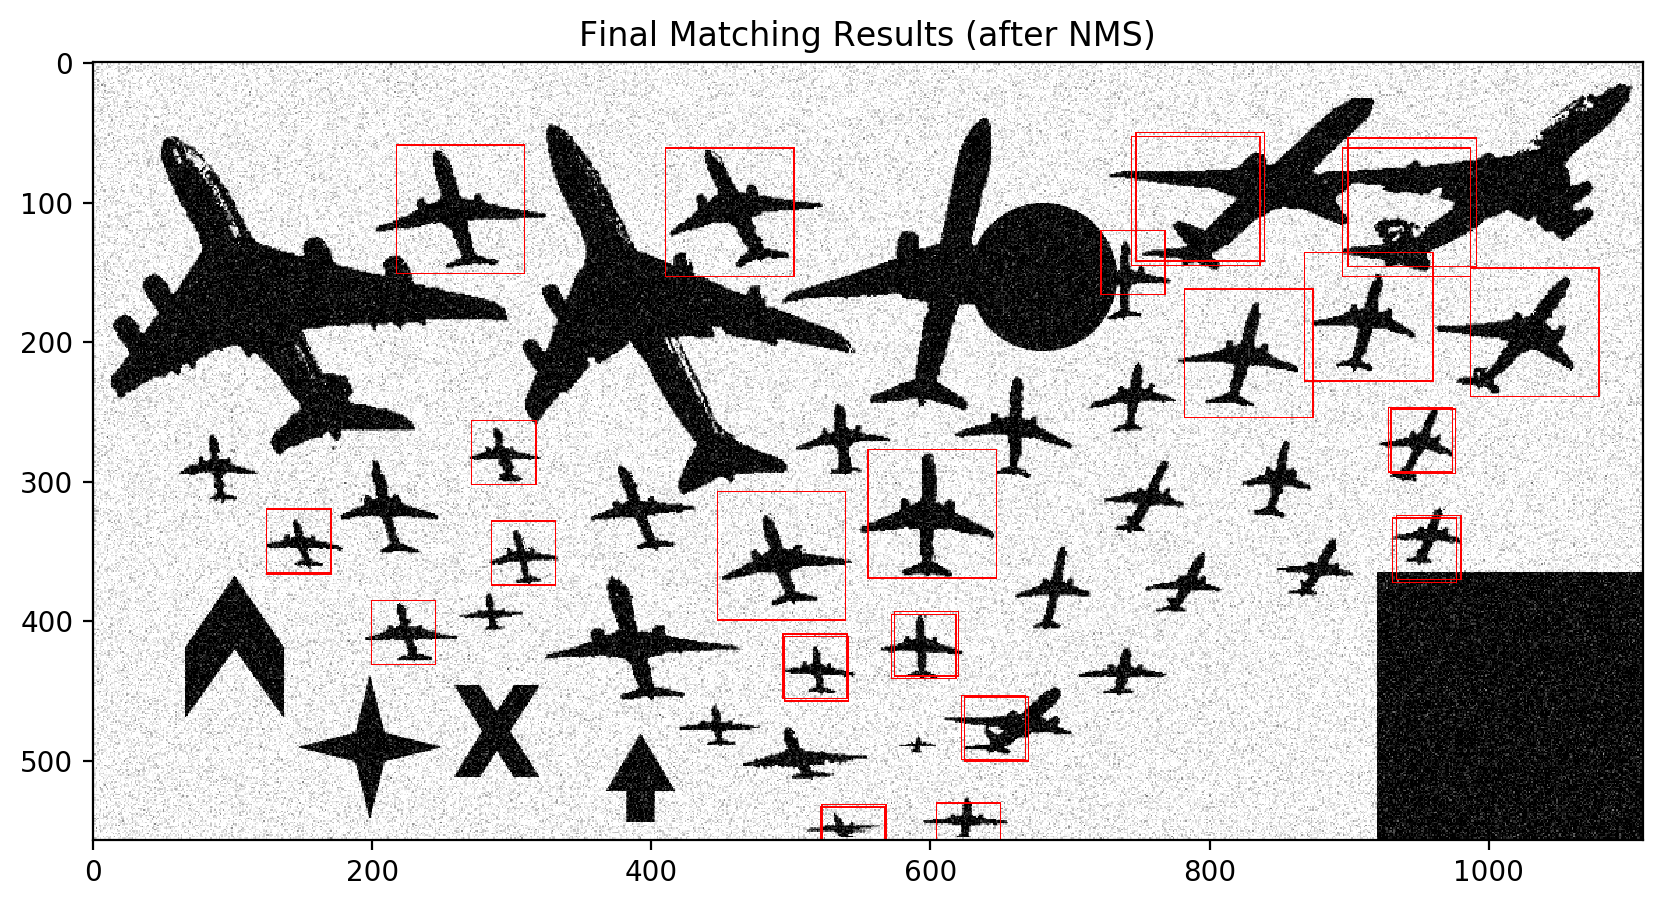

In [82]:
# Showing results after NMS
planes_image_rgb = cv2.imread('planes.png')
results = NMS(match_points, 0.3)
for result in results:
    planes_image_rgb = cv2.rectangle(planes_image_rgb,
                                     (result[1] - int(result[3] / 2), result[0] - int(result[2] / 2)),
                                     (result[1] + int(result[3] / 2), result[0] + int(result[2] / 2)), (255, 0, 0),
                                     1)
show_cv2_image(planes_image_rgb, 'Final Matching Results (after NMS)')

In [ ]:
# h) processing takes about 13 seconds